In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [15]:
df = pd.read_csv('data/df_grouped.csv')

In [16]:
# showing the media costo alla locazione column
df["Media Costo alla Vendita"].head()

0     422.5
1     460.0
2    1000.0
3     480.0
4     422.5
Name: Media Costo alla Vendita, dtype: float64

In [17]:
x_vars = ["Indice di spopolamento","Indice di occupazione","Indice disoccupazione","Tipo di località_Altri comuni non altrimenti classificati","Tipo di località_Capoluogo senza specifici interessi turistici","Tipo di località_Città d\'Arte","Tipo di località_Località collinari","Tipo di località_Località lacuali","Tipo di località_Località marine","Tipo di località_Località montane","Tipo di località_Località religiose","Tipo di località_Località termali", "PC_Economica","PC_Turistica_1","PC_Turistica_2", "PC_Turistica_3", "PC_Turistica_4", "PC_Turistica_5", "PC_Turistica_6", "PC_Turistica_7", "PC_Turistica_8", "PC_Turistica_9", "PC_Turistica_10", "PC_Turistica_11", "PC_Turistica_12", "Macroarea_Isole", "Macroarea_Nord", "Macroarea_Sud","Descrizione_Tipologia_di_Immobile_Abitazioni_di_tipo_economico", "Descrizione_Tipologia_di_Immobile_Abitazioni_signorili", "Descrizione_Tipologia_di_Immobile_Abitazioni_tipiche_dei_luoghi","Descrizione_Tipologia_di_Immobile_Ville_e_Villini"]

In [18]:
X = df[x_vars]
y= df['Media Costo alla Vendita']

In [19]:
# sostituisci valori nan dal dataset con 0
X = X.fillna(0)

In [20]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Choose alpha values
alpha_penalty = 0.5

# Initialize models with parameters
lm = LinearRegression()
ridge = Ridge(alpha=alpha_penalty)
lasso = Lasso(alpha=alpha_penalty)
elasticnet = ElasticNet(alpha=alpha_penalty, l1_ratio=0.5)

# Fit models
lm.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
elasticnet.fit(X_train, y_train)

# Make predictions
y_pred_lm = lm.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_elasticnet = elasticnet.predict(X_test)

# Compute performance metrics
metrics = {
    'Simple': (r2_score(y_test, y_pred_lm), mean_squared_error(y_test, y_pred_lm), mean_absolute_error(y_test, y_pred_lm)),
    'Ridge': (r2_score(y_test, y_pred_ridge), mean_squared_error(y_test, y_pred_ridge), mean_absolute_error(y_test, y_pred_ridge)),
    'Lasso': (r2_score(y_test, y_pred_lasso), mean_squared_error(y_test, y_pred_lasso), mean_absolute_error(y_test, y_pred_lasso)),
    'ElasticNet': (r2_score(y_test, y_pred_elasticnet), mean_squared_error(y_test, y_pred_elasticnet), mean_absolute_error(y_test, y_pred_elasticnet))
}

# Create a dataframe with the results
comparison_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['R2', 'MSE', 'MAE']).reset_index()
comparison_df.rename(columns={'index': 'Model'}, inplace=True)


In [21]:
# Function to apply color gradient row-wise
def color_gradient(val, min_val, max_val, inverse=False):
    """Returns a color based on a gradient from darkgreen (best) to darkred (worst), 
    with an inverse option for R2 where darkgreen is the lowest value."""
    norm = (val - min_val) / (max_val - min_val) if max_val > min_val else 0
    if inverse:
        norm = 1 - norm  # Invert gradient for R2

    r = int(139 + norm * (255 - 139))  # Dark Red to Red
    g = int(69 + (1 - norm) * (139 - 69))  # Green component decreases
    b = int(0)  # Keep a dark tone
    return f'background-color: rgb({r},{g},{b})'

def apply_row_gradient(col):
    inverse = col.name == 'R2'  # Apply inverse gradient for R2
    min_val, max_val = col.min(), col.max()
    return [color_gradient(v, min_val, max_val, inverse=inverse) for v in col]

# Apply highlighting and display
styled_df = comparison_df.style.apply(apply_row_gradient, subset=['R2', 'MSE', 'MAE'])


In [22]:
# Display highlighted comparison
styled_df

,Model,R2,MSE,MAE
0,Simple,0.507975,312560.905681,326.217426
1,Ridge,0.507986,312554.434573,326.217052
2,Lasso,0.506572,313452.726185,326.075640
3,ElasticNet,0.451513,348428.741315,330.971410


## R2 (Coefficiente di Determinazione):
Misura la proporzione di varianza della variabile dipendente (prezzo casa) spiegata dal modello

## MSE (Mean Squared Error):
- Misura media degli errori al quadrato
- Valori più bassi = Migliore precisione del modello

## MAE (Mean Absolute Error):
- Media dei valori assoluti degli errori
- Valori più bassi = Migliore precisione


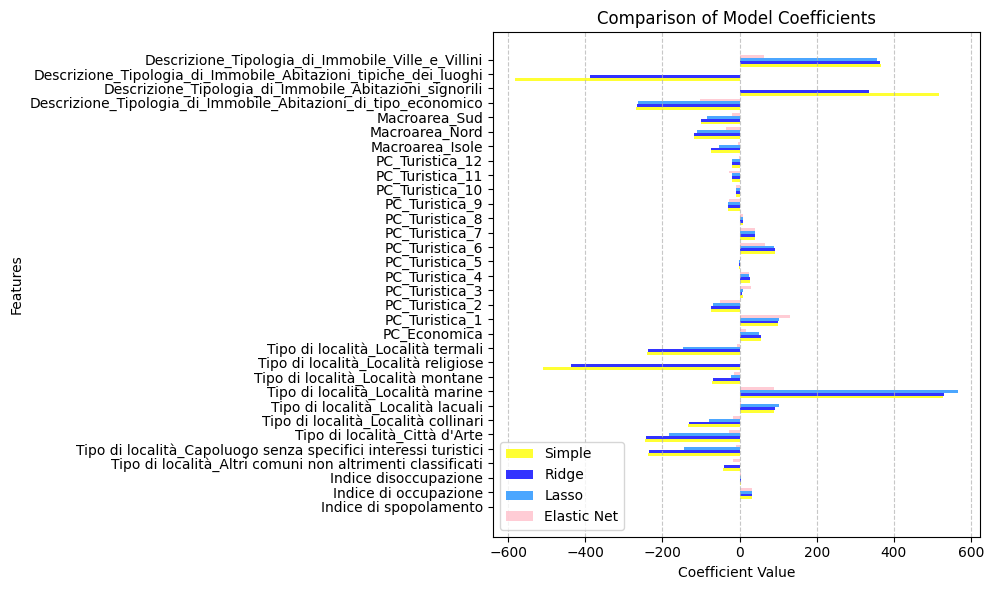

In [23]:
# Extract model coefficients
simple_linear_coefs = lm.coef_
ridge_coefs = ridge.coef_
lasso_coefs = lasso.coef_
elastic_net_coefs = elasticnet.coef_

# Define model names and feature names
models = ["Simple", "Ridge", "Lasso", "Elastic Net"]
features = [f"Feature {i}" for i in range(X_train.shape[1])]

# Set parameters for the bar chart
n_features = len(x_vars)
indices = np.arange(n_features)
bar_width = 0.20  # Width of each bar group
alpha_transp = 0.8  # Transparency level for bars

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))

plt.barh(indices - bar_width*2, simple_linear_coefs, bar_width, label="Simple", color="yellow", alpha=alpha_transp)
plt.barh(indices - bar_width, ridge_coefs, bar_width, label="Ridge", color="blue", alpha=alpha_transp)
plt.barh(indices, lasso_coefs, bar_width, label="Lasso", color='dodgerblue', alpha=alpha_transp)
plt.barh(indices + bar_width, elastic_net_coefs, bar_width, label="Elastic Net", color="pink", alpha=alpha_transp)

plt.ylabel("Features")
plt.xlabel("Coefficient Value")
plt.title("Comparison of Model Coefficients")
plt.yticks(indices, x_vars)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Apply grid only to x-axis
plt.legend()
plt.tight_layout()
plt.show()

## Visualizzazione dei coefficienti dei modelli per le variabili del df:
- Range da -600 a +600
- Mostra l'impatto di ogni variabile sul prezzo degli immobili

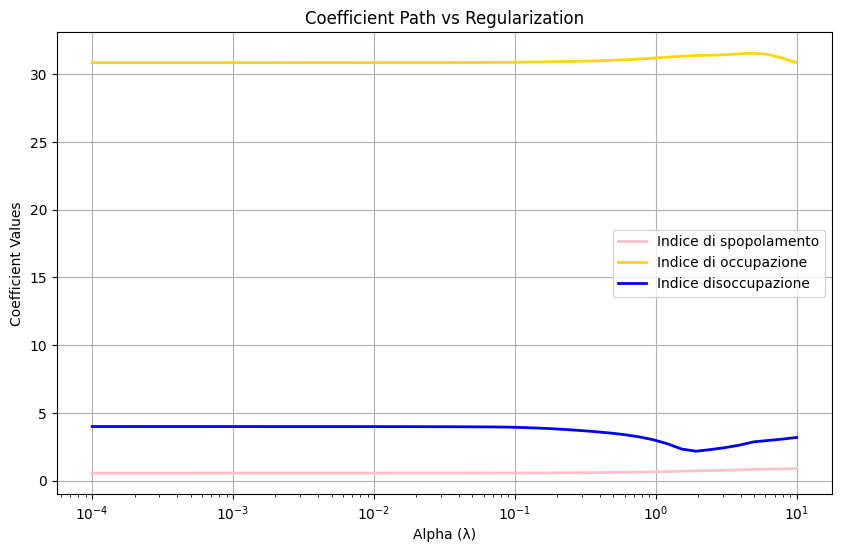

In [24]:
# Test different values of lambda (alpha) for Lasso regression
alphas = np.logspace(-4, 1, 50)
coefs = []

for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)

# Plot the coefficient path
plt.figure(figsize=(10, 6))
plt.plot(alphas, np.array(coefs)[:, 0], label=x_vars[0], color="pink", linewidth=2)
plt.plot(alphas, np.array(coefs)[:, 1], label=x_vars[1], color="gold", linewidth=2)
plt.plot(alphas, np.array(coefs)[:, 2], label=x_vars[2], color="blue", linewidth=2)
plt.xscale('log')
plt.xlabel("Alpha (λ)")
plt.ylabel("Coefficient Values")
plt.title("Coefficient Path vs Regularization")
plt.legend()
plt.grid(True)
plt.show()